## Imports

In [9]:
import os
import numpy as np
import cv2 as cv
import requests
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

## Data Preparation and augmentation

In [4]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Preprocessing for validation (without augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [5]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    'datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    'datasets/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 922 images belonging to 3 classes.
Found 203 images belonging to 3 classes.


In [6]:
train_generator.class_indices

{'adult_content': 0, 'safe': 1, 'unsafe': 2}

## Data distribution

Class Distribution: {0: 230, 1: 304, 2: 388}


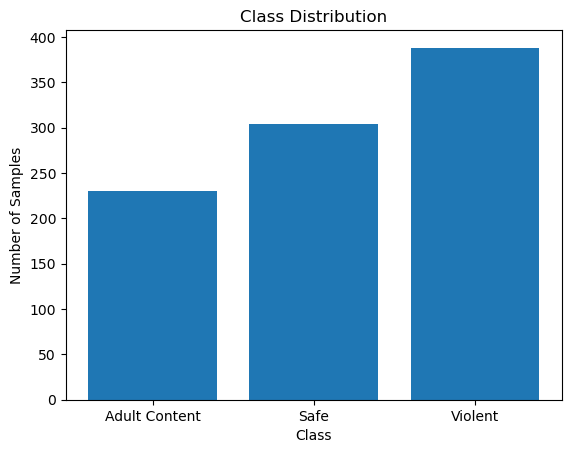

In [7]:
# Plot class distribution
class_counts = train_generator.classes
unique, counts = np.unique(class_counts, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xticks([0, 1, 2], ['Adult Content', 'Safe', 'Violent'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

## Model Training and evaluation

In [13]:
# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)       │ (None, 224, 224, 3)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)            │ (None, 224, 224, 64)     │         1,792 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)            │ (None, 224, 224, 64)     │        36,928 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)       │ (None, 112, 112, 64)     │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)            │ (None, 112, 112, 128)    │        73,856 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)            │ (None, 112, 112, 128)    │       147,584 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)       │ (None, 56, 56, 128)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)            │ (None, 56, 56, 256)      │       295,168 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)            │ (None, 56, 56, 256)      │       590,080 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)            │ (None, 56, 56, 256)      │       590,080 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)       │ (None, 28, 28, 256)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)            │ (None, 28, 28, 512)      │     1,180,160 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)            │ (None, 28, 28, 512)      │     2,359,808 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)            │ (None, 28, 28, 512)      │     2,359,808 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)       │ (None, 14, 14, 512)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)            │ (None, 14, 14, 512)      │     2,359,808 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)            │ (None, 14, 14, 512)      │     2,359,808 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)            │ (None, 14, 14, 512)      │     2,359,808 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)       │ (None, 7, 7, 512)        │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten_1 (Flatten)              │ (None, 25088)            │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                  │ (None, 512)              │    12,845,568 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_4 (Dropout)              │ (None, 512)              │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                  │ (None, 3)                │         1,539 │
└──────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

 #unfreezing the last 4 layers
for layer in base_model.layers[-4:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# finetune the model
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 539s 18s/step - accuracy: 0.6088 - loss: 27.3547 - val_accuracy: 0.8177 - val_loss: 7.4121
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step - accuracy: 0.7812 - loss: 9.0039 - val_accuracy: 0.8182 - val_loss: 4.4484
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 360s 12s/step - accuracy: 0.7922 - loss: 9.7088 - val_accuracy: 0.8333 - val_loss: 3.5366
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.8750 - loss: 1.4850 - val_accuracy: 0.8182 - val_loss: 1.8091
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 352s 12s/step - accuracy: 0.8640 - loss: 3.2954 - val_accuracy: 0.8906 - val_loss: 1.8036
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.8438 - loss: 2.8866 - val_accuracy: 0.7273 - val_loss: 9.3328
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 345s 12s/step - accuracy: 0.9081 - loss: 0.8614 - val_accuracy: 0.8594 - val_loss: 1.7725
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.8125 - loss: 0.5469 - val_accurac

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.8684 - loss: 0.9126
Validation Accuracy: 86.21%


## Save the model

In [16]:
from tensorflow.keras.models import save_model
save_model(model, 'keras_model.keras')
print("Model Saved")

Model Saved


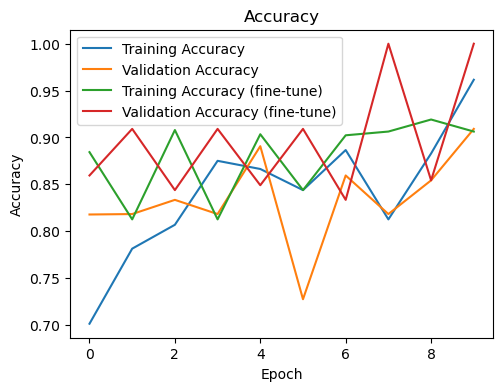

In [17]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy (fine-tune)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (fine-tune)')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

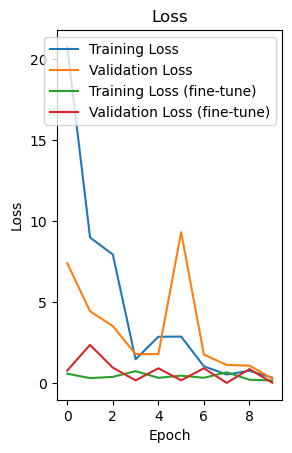

In [18]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine_tune.history['loss'], label='Training Loss (fine-tune)')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (fine-tune)')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()